In [1]:
from glob import glob
import pandas as pd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import os
from skimage.measure import block_reduce
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import rasterio as rio
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:

sentinel_bands = glob(r"C:\Users\bright\Desktop\aim_ishango\data\IMG_DATA\R10m\*B?*.jp2")

sentinel_bands.sort()
 
l = []

for i in sentinel_bands:
  with rio.open(i, 'r') as f:
    #print(i)
    #print(f.shape)
    #print('---------------------------------------------')
    l.append(f.read(1))
    


In [4]:
stackBand = np.stack(l)

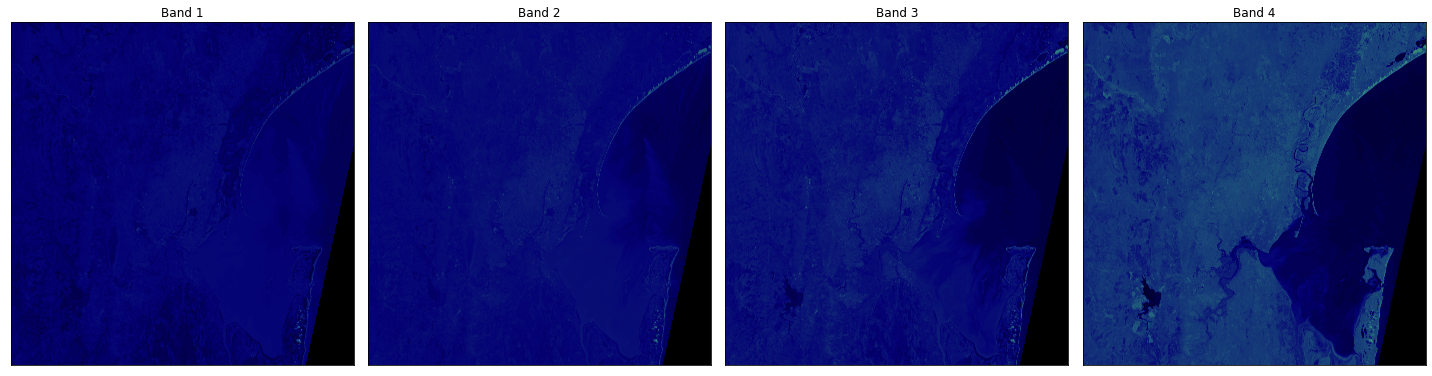

In [5]:
#Visualizing all the bands....
ep.plot_bands(stackBand, cmap = 'gist_earth', figsize = (20,10), cols = 4, cbar = False)
plt.show()

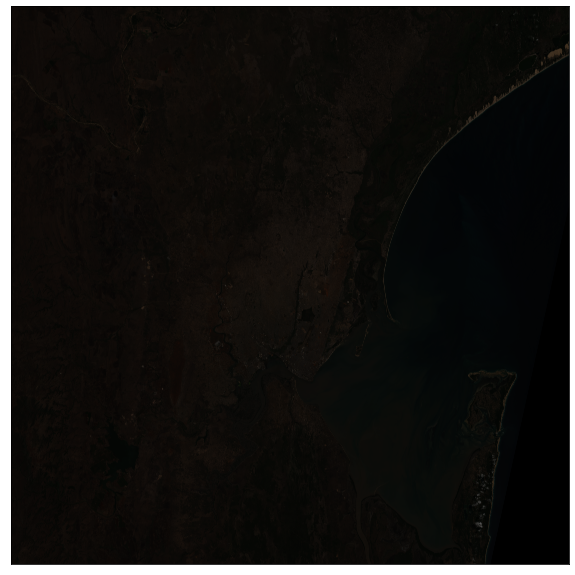

In [6]:
#RGB composite, visible to the eye
rgb = ep.plot_rgb(stackBand, rgb=(2,1,0), figsize=(10,16))
plt.show()

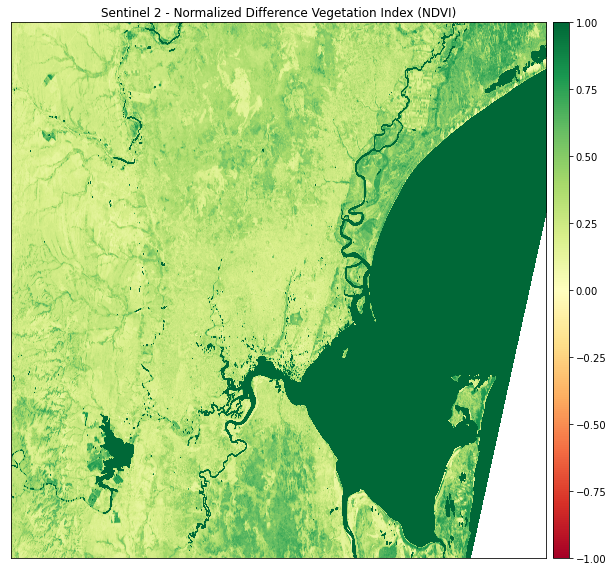

In [7]:
#NDVI of the area, Vlaues close to 1 showing vegetation such as crops
titles = ["Sentinel 2 - Normalized Difference Vegetation Index (NDVI)"]
ndvi = es.normalized_diff(stackBand[3], stackBand[2])

ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=titles, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

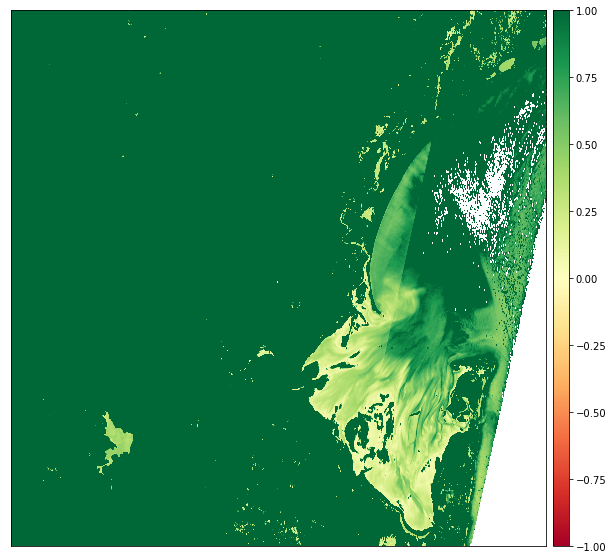

In [8]:
#Visible Atmospherically Resistant Index, Emphasis on vegetaion while mitigating atmospheric and illumination effects
#vari = (green-red)/(green + red - blue)
vari = (stackBand[1]-stackBand[2])/((stackBand[1]+stackBand[2])-stackBand[0])
ep.plot_bands(vari, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

In [9]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_sentinel_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_sentinel_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_sentinel_class
)
np.unique(ndvi_sentinel_class)

masked_array(data=[2, 3, 4, 5, --],
             mask=[False, False, False, False,  True],
       fill_value=999999,
            dtype=int64)

In [32]:
ndvi_sentinel_class.shape

(10980, 10980)

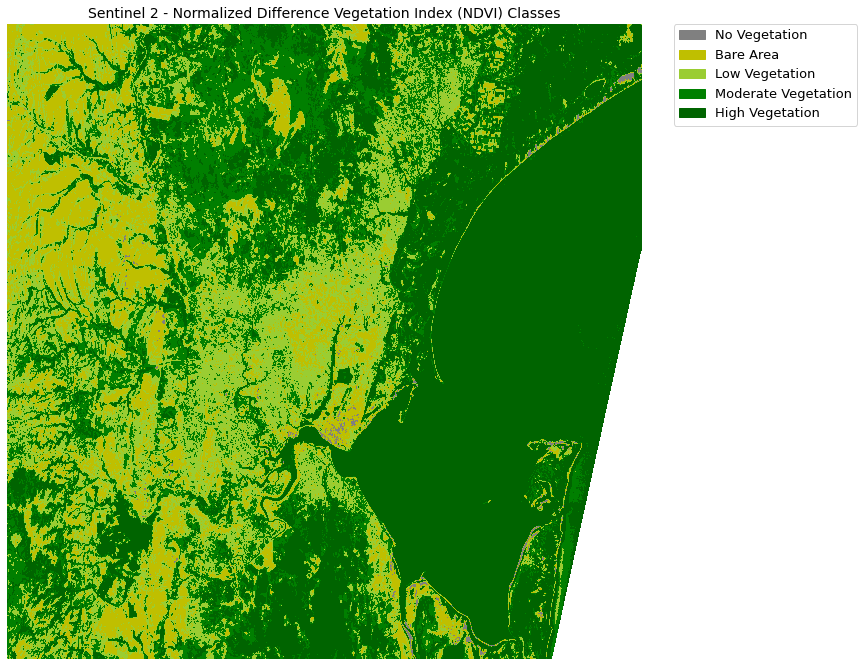

In [10]:
# Define color map
nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "Moderate Vegetation",
    "High Vegetation",
]

# Get list of classes
classes = np.unique(ndvi_sentinel_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# Plot your data
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(ndvi_sentinel_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Sentinel 2 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()

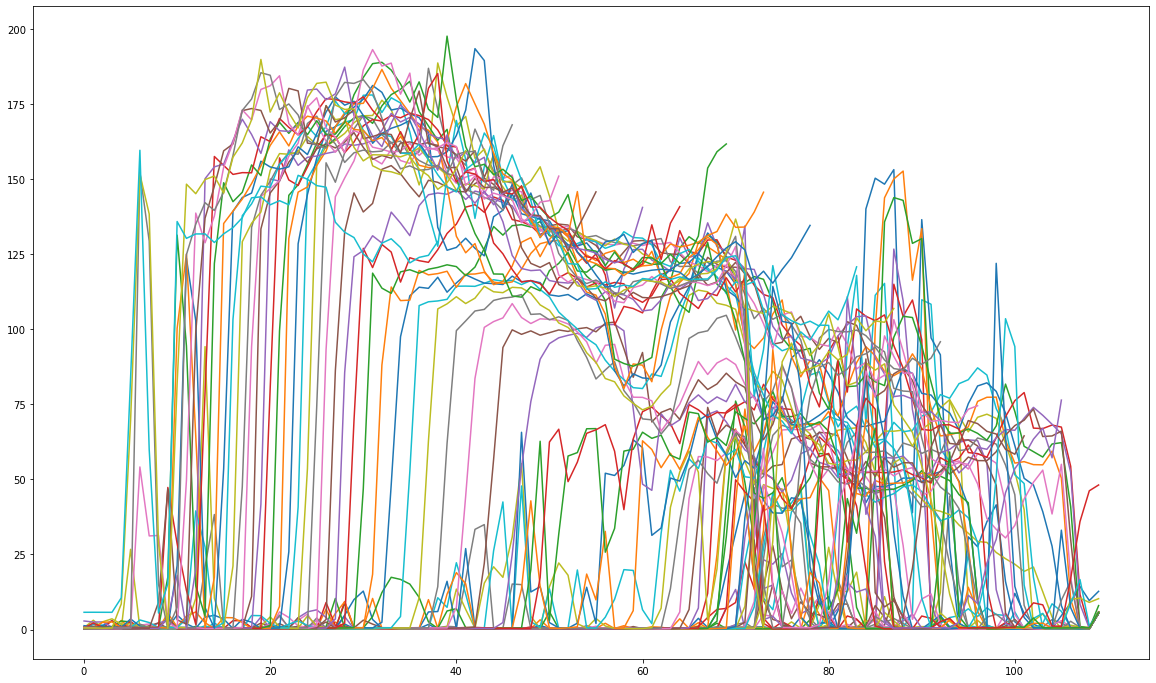

In [11]:
# Dimensions reduced to make the ndvi timeseries more explainable. The mean value at n instances is replaced by the mean value
# The resulting result is a reduced dimension from 10980 x 10980 t0 110x110, each pixel representing a kilometer
ndvi_pixel_reduced = block_reduce(ndvi, block_size=(100,100), func=np.mean, cval=np.mean(ndvi))
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.figure(figsize=(20, 12))
plt.plot(ndvi_pixel_reduced)
plt.show()

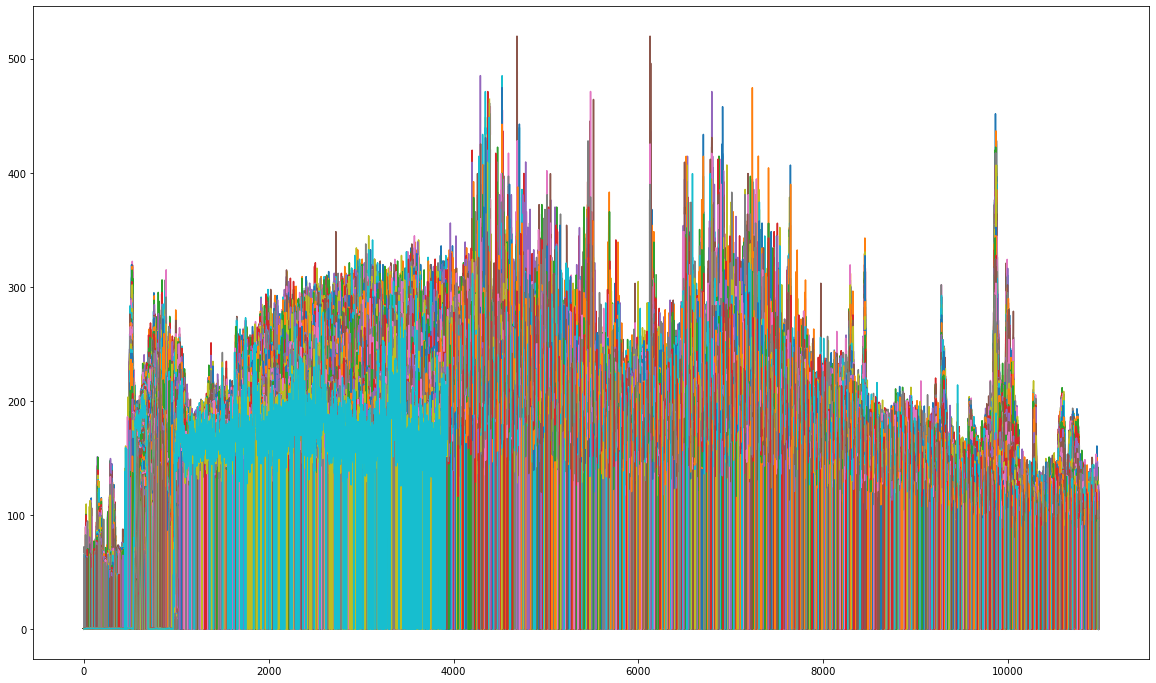

In [18]:
#Plot of ndvi values(unreduced)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.figure(figsize=(20, 12))
plt.plot(ndvi)
plt.show()